# <a id='toc1_'></a>[**EDA Template**](#toc0_)

Name  
Topic  
email  
June 4th, 2023  


**Table of contents**<a id='toc0_'></a>    
- [**EDA Template**](#toc1_)    
  - [Setup](#toc1_1_)    
  - [**Exploratory Data Analysis**](#toc1_2_)    
    - [Univariate Analysis](#toc1_2_1_)    
    - [Bivariate Analysis](#toc1_2_2_)    
    - [Clustering Analysis](#toc1_2_3_)    
  - [Insights and Conclusions](#toc1_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Setup](#toc0_)

These are the necessary libraries to import

In [45]:
# Import all libraries
from capstone_functions import *

master_df = pd.read_parquet("../Data/master_df.parquet")

# Set the random.seed(42)
np.random.seed(42)


## <a id='toc1_2_'></a>[**Exploratory Data Analysis**](#toc0_)


### <a id='toc1_2_1_'></a>[Basic EDA: Univariate Analysis](#toc0_)

Non-Numerical Features:


In [46]:
# Import the function to load the Iris dataset from sklearn.datasets
dfSummary(master_df, is_collapsible=True)


No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,cancel_events[Float64],Mean (sd) : 1.3 (0.9)min < med < max:0.0 < 2.0 < 2.0IQR (CV) : 2.0 (1.4),3 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKQAAABACAYAAACUYNzVAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjYuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8o6BhiAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABgUlEQVR4nO3dQWrCQBiG4ZkiopsEETyMh+hhewhvI2VctKWg6baLxmIa6Vf6PNthJMpLYGD4rcMwFEjx8NsPAJ8tfvsB+JtqretSynLi9vdhGF6/WhAkN6u1rrfb7WPXdZsp+0+n03Ot9emrKAXJFMuu6zb7/f617/u3Wza21laHw2FzPB6XpRRBMp++7992u93LhK3rsQWHGqIIkiiCJIogiSJIogiSKIIkiiCJIkiiCJIogiSKIIkiSKIIkiiCJIogiSJIogiSKIIkiiCJIkiiCJIogiSKIIlydVDAvea3wJjRIO85vwXGXHtD3m1+C4z5drbPPea3wBiHGqIIkiiCJIogiSJIogiSKIIkiiCJIkiiCJIogiSKIInij5Nm4u7oPAQ5A3dH5yPIebg7OhNBzsjd0Z9zqCGKIIkiSKIIkiiCJIogiSJIogiSKIIkiiCJIkiiCJIogiTKt7d9WmurWz+0tbY6n8+LUkpXa530YH9Md7lcFv/ot/rR9722/gEB/nb2TjvfLQAAAABJRU5ErkJggg=="">",0(0.0%)
2,gatherings_restrictions[Float64],Mean (sd) : 2.5 (1.8)min < med < max:0.0 < 4.0 < 4.0IQR (CV) : 4.0 (1.4),5 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKQAAABACAYAAACUYNzVAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjYuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8o6BhiAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABnklEQVR4nO3dQWrCQBhA4X+KiG4miOBhPEQP20PkNlLGRZWCptsujJK0IW/C+7ZhzCwegRn4MXVdFxLF29wbkH5bzb0B1SmltI2I9cjl313XXR49MEgNllLa7vf795zzbsz68/n8mVL6eBSlQWqMdc55dzweL03TXIcsLKVs2rbdnU6ndUQYpP5P0zTXw+HwNWLptu+BhxqhGKRQDFIoBikUgxSKQQrFIIVikEIxSKEYpFAMUigGKRSDFIpBCsUghWKQQjFIoRikUAxSKAYplKdDXlPN3kp9eoOccvZW6vPsCznZ7K3U5+Vc9hSzt1IfDzVCMUihGKRQDFIoBikUgxSKQQrFIIVikEIxSKEYpFAMUigGKRSDFIpBCsUghWKQQjFIoRikUAxSKP75ZuWWNjtvkBVb4uy8QdZtcbPzBrkAS5qd91AjFIMUikEKxSCFYpBCQZ6ya7zsrXHPRLgga7zsrXHPVLggo87L3hr3jEQMMiLqvOytcc80L4MspWyG/mgpZXO73VYRkVNKQ5fn+/2+muG9fzHXnqt877PnPxKIx/g7iLtUAAAAAElFTkSuQmCC"">",0(0.0%)
3,infected[Int64],Mean (sd) : 1529243.3 (1862254.2)min < med < max:15.0 < 1007507.5 < 13384650.0IQR (CV) : 1211292.2 (0.8),"1,136 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKQAAABACAYAAACUYNzVAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjYuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8o6BhiAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACDElEQVR4nO3cQYvaQBiH8feNq8TVZlBBb15678Gj9177YXvt3W/RuwiyRpyuKGl6KvRSt5mQ7h/y/K4yEw0PhgnDeF3XBqjI3vsLAH96evShu4/NbJQ4962u69fEseipvwbp7uPFYvGlKIpZysTn8/nF3b8SJZp49A85Kopitt1uX0MI1yaTlmWZ73a72fF4HJkZQeKfPXxkm5mFEK7L5fJHwtzjhDHoORY1kEKQkEKQkEKQkEKQkEKQkEKQkEKQkEKQkEKQkEKQkEKQkEKQkEKQkEKQkEKQkEKQkEKQkEKQkEKQkEKQkEKQkEKQkEKQkEKQkEKQkEKQkEKQkEKQkEKQkEKQkEKQkEKQkPLmCbqpqqoamlnh7inDOTC/pzoJMsY4vN/vn9br9WAwGDQ6n9yMA/P7rJMgb7fbU57nz5vN5rparV6ajOXA/H7r7JFtZjaZTDgwH42wqIEUgoQUgoQUgoQUgoQUgoQUgoQUgoQUgoQUgoQUgoQUgoQUgoSUTnf7pGJzb3/JBcnm3n6TC5LNvf0mF+RvbO7tJxY1kEKQkCL7yE7VcoWemdnPxEu/y+re3cdmNkoc3ub3dnKv3gyyLMu86dUul0tuZhZjzA+Hw/P/Grvf7z+krtCrqhrGGD9Op9PvWZbdm4w1MzudThd3/2Zmjd8MtJDP5/PPIYRp04Ftfm/be/XoTcgvxlvEIqz1HH8AAAAASUVORK5CYII="">",0(0.0%)
4,information_campaigns[Float64],Mean (sd) : 1.9 (0.3)min < med < max:0.0 < 2.0 < 2.0IQR (CV) : 0.0 (6.1),2 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKQAAABACAYAAACUYNzVAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjYuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8o6BhiAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABhklEQVR4nO3XQUrDQBxG8flLiWYzIUR7jB6gh+hhe4hue5JQkoVRFx23LtpKotAnvt92+IZZPAKJUkqSKB7u/QDpq9W9H6C/KSLqlFK1cP5RSpkuHRikZouIuuu6Xc65XbIfx/EUEftLURqklqhyzu12u52apnmbMxyG4elwOLR931cpJYPU72ma5m29Xr8umNbXDvypEYpBCsUghWKQQjFIoRikUAxSKAYpFIMUikEKxSCFYpBCMUihGKRQDFIoBikUgxSKQQrFIIVikEIxSKEYpFAMUigGKRSDFIpBCsUghWKQQjFIoRikUAxSKAYpFIMUikEKxSCFYpBCMUihGKRQDFIoBikUgxSKQQrFIIVikEIxSKEYpFAMUigGKRSDFIpBCsUghWKQQjFIoRikUAxSKKtbhxFRp5SqhXd/lFKmhVv9U1eDjIi667pdzrldcvE4jqeI2Bul5rj1haxyzu1ms0l1Xb/PuXSapsfj8fjS9/1zRIw/fKN48vl8Xg3D8DR3+N3mE0BwQlVccQFoAAAAAElFTkSuQmCC"">",0(0.0%)
5,internal_movement_restrictions[Float64],Mean (sd) : 1.4 (0.5)min < med < max:0.0 < 1.0 < 2.0IQR (CV) : 1.0 (2.6),3 distinct values,"<img src = ""data:i

In [47]:
# master_df_final_set = master_df[master_df.index.date < dt.date(2022, 6, 18)].copy()

master_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1142 entries, 2020-02-15 to 2023-04-01
Data columns (total 59 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   cancel_events                         1142 non-null   Float64
 1   gatherings_restrictions               1142 non-null   Float64
 2   infected                              1142 non-null   Int64  
 3   information_campaigns                 1142 non-null   Float64
 4   internal_movement_restrictions        1142 non-null   Float64
 5   international_movement_restrictions   1142 non-null   Float64
 6   school_closing                        1142 non-null   Float64
 7   stay_home_restrictions                1142 non-null   Float64
 8   stringency_index                      1142 non-null   Float64
 9   susceptible                           1142 non-null   Float64
 10  testing_policy                        1142 non-null   Float64
 11 

In [48]:
# Creating subplots vertically aligned
fig = make_subplots(rows=3, cols=1, shared_xaxes=True, subplot_titles=("Daily Confirmed", "Daily Hospitalizations", "Daily Fatalities"))

# Adding traces for each subplot
fig.add_trace(go.Scatter(x=master_df.index, y=master_df['new_confirmed'], name='Daily Confirmed'), row=1, col=1)
fig.add_trace(go.Scatter(x=master_df.index, y=master_df['new_hospitalized_patients'], name='Daily Hospitalizations'), row=2, col=1)
fig.add_trace(go.Scatter(x=master_df.index, y=master_df['new_fatal'], name='Daily Fatalities'), row=3, col=1)

# Update the layout
fig.update_layout(height=800, width=1000, title='Daily Confirmed Cases, Hospitalizations, and Fatalities over Time')
fig.update_xaxes(title_text='Date', row=3, col=1)
fig.update_yaxes(title_text='Daily Confirmed Cases', row=1, col=1)
fig.update_yaxes(title_text='Daily Hospitalizations', row=2, col=1)
fig.update_yaxes(title_text='Daily Fatalities', row=3, col=1)

fig.show()


In [49]:

target_columns = ['new_hospitalized_patients', 'new_fatal', 'new_confirmed']

master_df['new_confirmed_ra'] = master_df['new_confirmed'].rolling(window=7).mean()
master_df['new_hospitalized_patients_ra'] = master_df['new_hospitalized_patients'].rolling(window=7).mean()
master_df['new_fatal_ra'] = master_df['new_fatal'].rolling(window=7).mean()

master_daily = master_df[target_columns]
master_daily.head()

,new_hospitalized_patients,new_fatal,new_confirmed
date,,,
2020-02-15,0.0,0,0
2020-02-16,0.0,0,0
2020-02-17,0.0,0,10
2020-02-18,0.0,0,0
2020-02-19,0.0,0,0


In [50]:
weekly_mean = master_df.resample('W').mean()
weekly_z_score = (weekly_mean - weekly_mean.mean()) / weekly_mean.sem()
weekly_sum = master_df.resample('W').sum()

monthly_mean = master_df.resample('M').mean()
monthly_z_score = (monthly_mean - monthly_mean.mean()) / monthly_mean.sem()
monthly_sum = master_df.resample('M').sum()



In [51]:

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=master_df.index, y=master_df['new_confirmed_ra'], name='Confirmed (7-day RA)'), secondary_y=False)
fig.add_trace(go.Scatter(x=master_df.index, y=master_df['new_hospitalized_patients_ra'], name='Hospitalizations (7-day RA)'), secondary_y=True)
fig.add_trace(go.Scatter(x=master_df.index, y=master_df['new_fatal_ra'], name='Fatalities (7-day RA)'), secondary_y=True)

# Update the layout
fig.update_layout(title='Daily Confirmed Cases vs Hospitalizations/Deaths (with 7-day Rolling Average)',
                  xaxis_title='Date',
                  yaxis_title='Daily Confirmed Cases',
                  yaxis2_title='Hospitalizations/Deaths')

fig.update_xaxes(rangeslider_visible=True)

fig.show()





In [52]:
fig = px.bar(weekly_z_score.new_confirmed)

fig.update_layout(
    yaxis_title="", 
    yaxis_tickformat = '%',
    xaxis_title="",
    title="Monthly deviation from mean revenue (%)",
    showlegend=False,
)
fig.show()

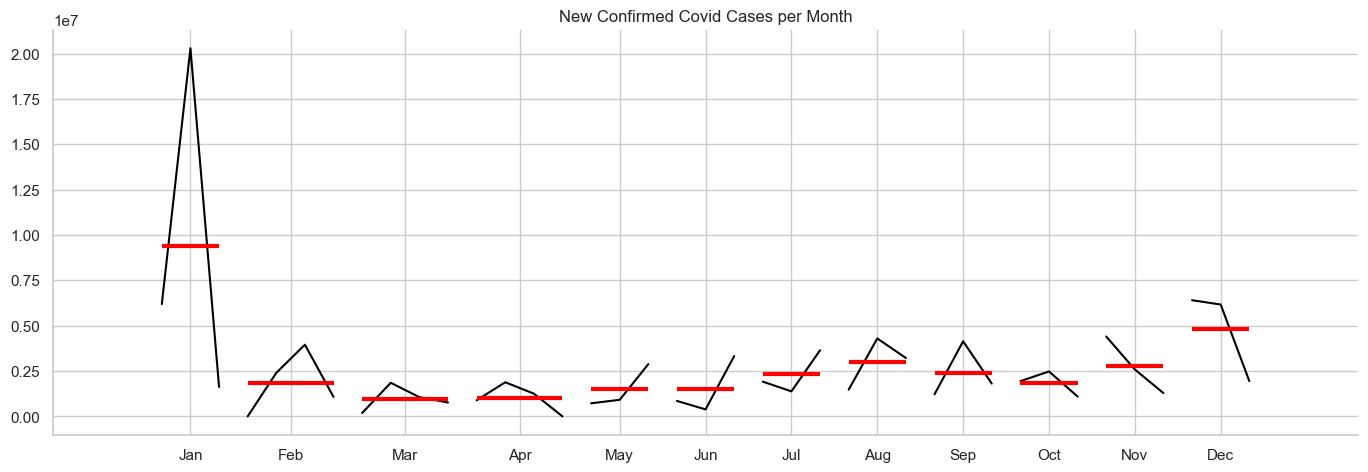

In [53]:


plt.figure(figsize=(15, 5))

# create the seasonal plot
month_plot(monthly_sum["new_confirmed"], ax=plt.gca())

plt.title("New Confirmed Covid Cases per Month")
sns.despine()
plt.show()

In [54]:
# Performing seasonal decomposition on 'new_confirmed' column
decomposition = tsa.seasonal_decompose(monthly_mean['new_confirmed'], model='additive', period=12)

# Adding the decomposition data to the dataframe
monthly_mean["Trend"] = decomposition.trend
monthly_mean["Seasonal"] = decomposition.seasonal
monthly_mean["Residual"] = decomposition.resid


# Performing seasonal decomposition on 'new_confirmed' weekly column
decomposition = tsa.seasonal_decompose(weekly_mean['new_confirmed'], model='additive', period=12)

# Adding the decomposition data to the dataframe
weekly_mean["Trend"] = decomposition.trend
weekly_mean["Seasonal"] = decomposition.seasonal
weekly_mean["Residual"] = decomposition.resid


In [55]:

# Creating subplots for the trend, seasonal, and residual components
cols = ["Trend", "Seasonal", "Residual"]
fig = make_subplots(rows=3, cols=1, subplot_titles=cols)

for i, col in enumerate(cols):
    fig.add_trace(go.Scatter(x=monthly_mean.index, y=monthly_mean[col], name=col), row=i+1, col=1)

fig.update_layout(height=800, width=1200, title='Seasonal Decomposition of Daily Confirmed Cases')
fig.show()


In [67]:

# Creating subplots for the trend, seasonal, and residual components
cols = ["Trend", "Seasonal", "Residual"]
fig = make_subplots(rows=3, cols=1, subplot_titles=cols)

for i, col in enumerate(cols):
    fig.add_trace(go.Scatter(x=weekly_mean.index, y=weekly_mean[col], name=col), row=i+1, col=1)

fig.update_layout(height=800, width=1200, title='Weekly Decomposition of Daily Confirmed Cases')
fig.show()


In [57]:
# Creating the seasonal difference again
monthly_mean["seasonal_difference"] = monthly_mean["new_confirmed"].diff(12)

# Plotting the seasonal difference
fig = px.line(monthly_mean, x=monthly_mean.index, y="seasonal_difference")

fig.update_layout(
    yaxis_title="Difference in Confirmed Cases", 
    xaxis_title="Date",
    title="Change in Confirmed Cases over Prior Year",
    xaxis_rangeslider_visible=True,
    xaxis_range=["2021-01-31", "2023-09-01"]
)

fig.show()

In [58]:
# Creating the seasonal difference again
weekly_mean["seasonal_difference"] = weekly_mean["new_confirmed"].diff(12)

# Plotting the seasonal difference
fig = px.line(weekly_mean, x=weekly_mean.index, y="seasonal_difference")

fig.update_layout(
    yaxis_title="Difference in Confirmed Cases", 
    xaxis_title="Date",
    title="Change in Confirmed Cases over Prior Year",
    xaxis_rangeslider_visible=True,
    xaxis_range=["2021-01-31", "2023-09-01"]
)

fig.show()

### Modeling

In [59]:
def mean_absolute_percentage_error(true_values, predicted_values):
    """
    Calculate the mean absolute percentage error. 
    Find the prediction error and devide by the true value, then average.
    """
    
    error = true_values - predicted_values
    absolute_percentage_error = np.abs(error/true_values)
    mape = absolute_percentage_error.mean() * 100
    
    return mape

# sns.set_style('darkgrid')

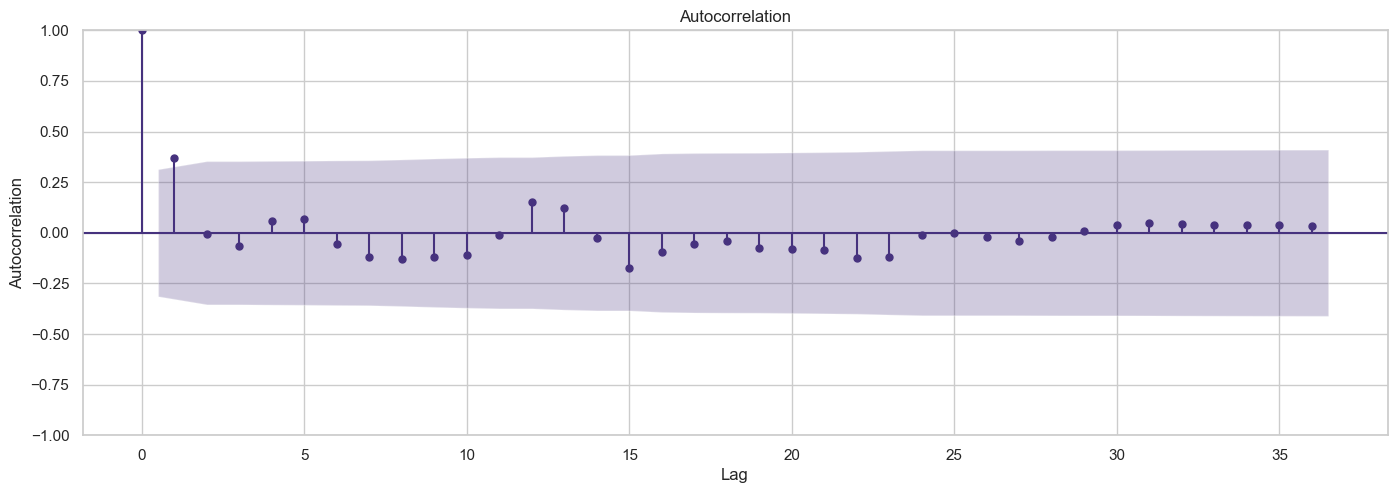

In [60]:

plt.figure(figsize=(15, 5))

# put the acf plot on the current axis
plot_acf(monthly_mean["new_confirmed"], lags=36, ax=plt.gca())
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()



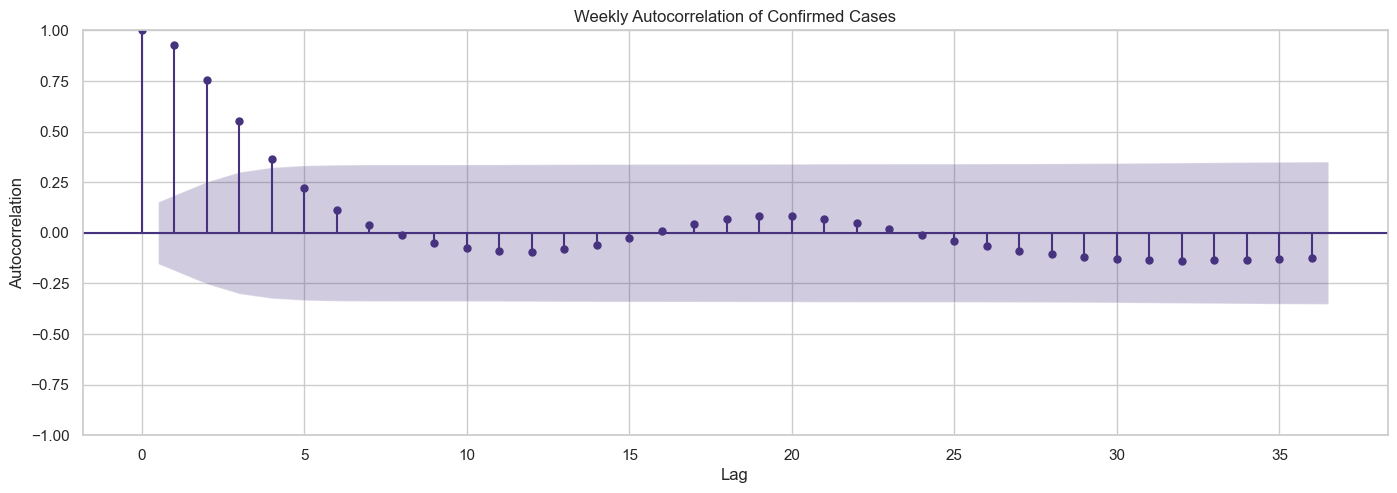

In [70]:

plt.figure(figsize=(15, 5))

# put the acf plot on the current axis
plot_acf(weekly_mean["new_confirmed"], lags=36, ax=plt.gca())
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Weekly Autocorrelation of Confirmed Cases')

plt.show()



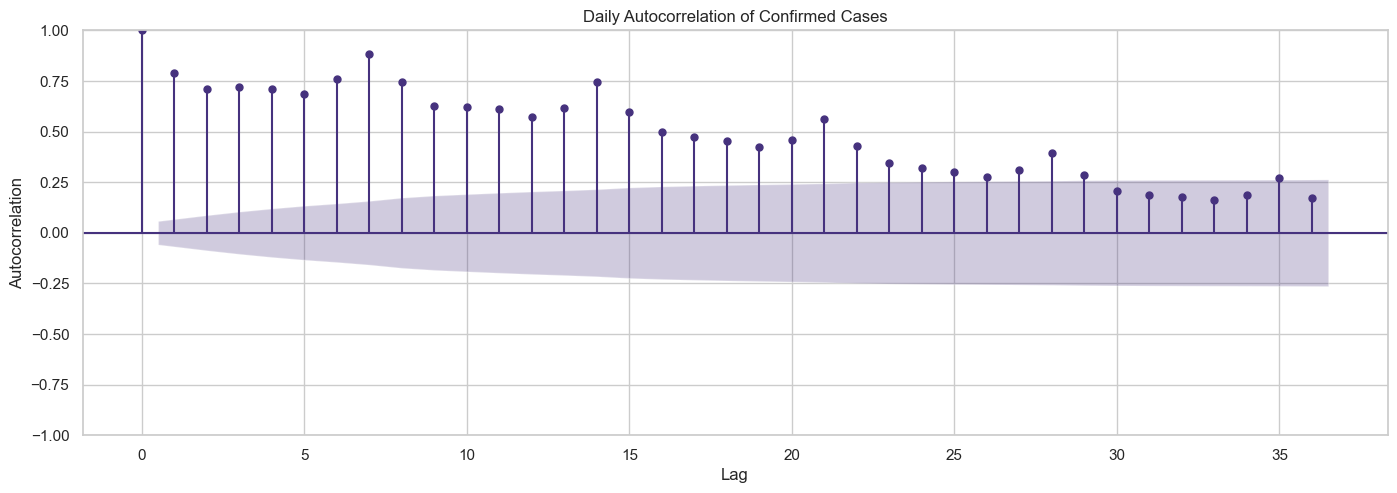

In [69]:

plt.figure(figsize=(15, 5))

# put the acf plot on the current axis
plot_acf(master_daily["new_confirmed"], lags=36, ax=plt.gca())
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')

plt.title('Daily Autocorrelation of Confirmed Cases')
plt.show()



c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



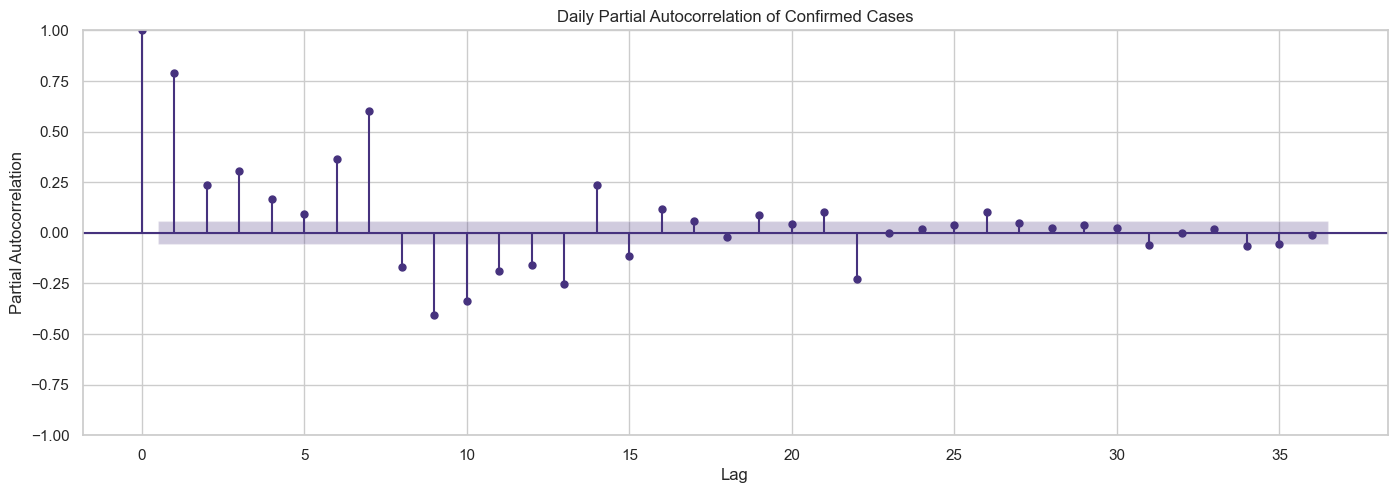

In [71]:
plt.figure(figsize=(15, 5))

# Use plot_pacf instead of plot_acf
plot_pacf(master_daily["new_confirmed"], lags=36, ax=plt.gca())
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')

plt.title('Daily Partial Autocorrelation of Confirmed Cases')

plt.show()


c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



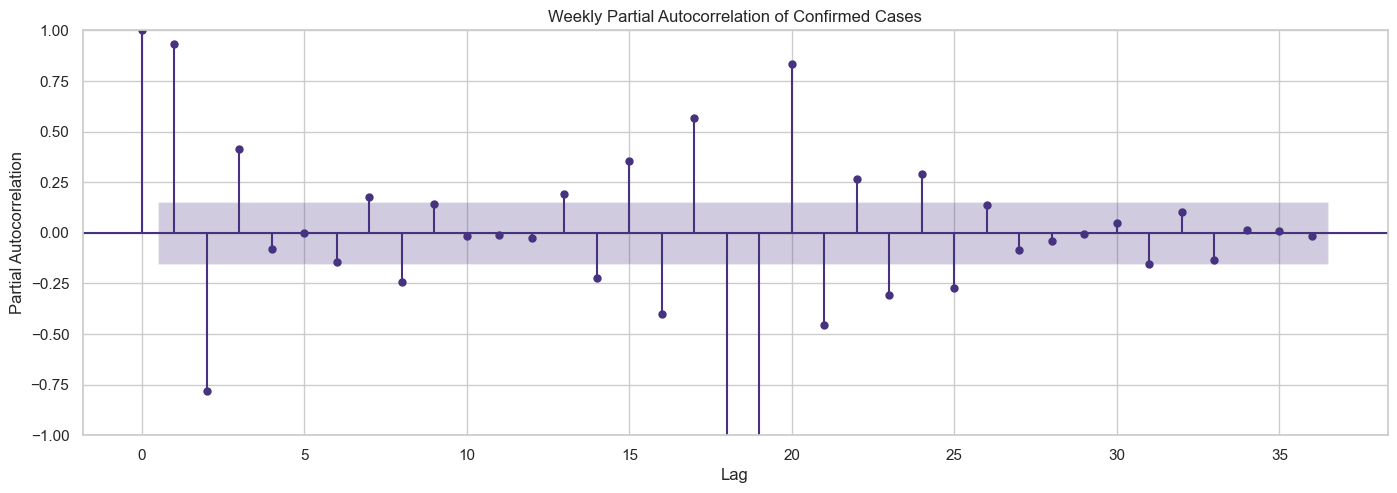

In [72]:
plt.figure(figsize=(15, 5))

# Use plot_pacf instead of plot_acf
plot_pacf(weekly_mean["new_confirmed"], lags=36, ax=plt.gca())
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')

plt.title('Weekly Partial Autocorrelation of Confirmed Cases')


plt.show()


c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



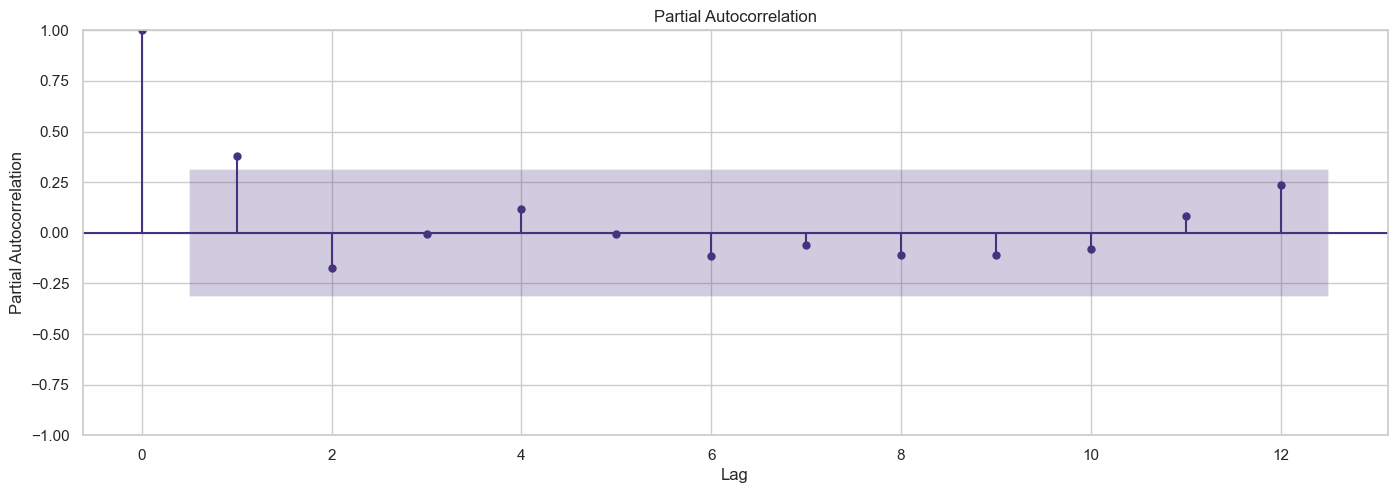

In [65]:
plt.figure(figsize=(15, 5))

# Use plot_pacf instead of plot_acf
plot_pacf(monthly_mean["new_confirmed"], lags=12, ax=plt.gca())
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()


In [66]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

p_param = 2

model = SARIMAX(train, order=(p_param, 0, 0), trend="c")
model_fit = model.fit(disp=0)

model_fit.summary()



NameError: name 'train' is not defined

### <a id='toc1_2_2_'></a>[Basic EDA: Bivariate Analysis](#toc0_)

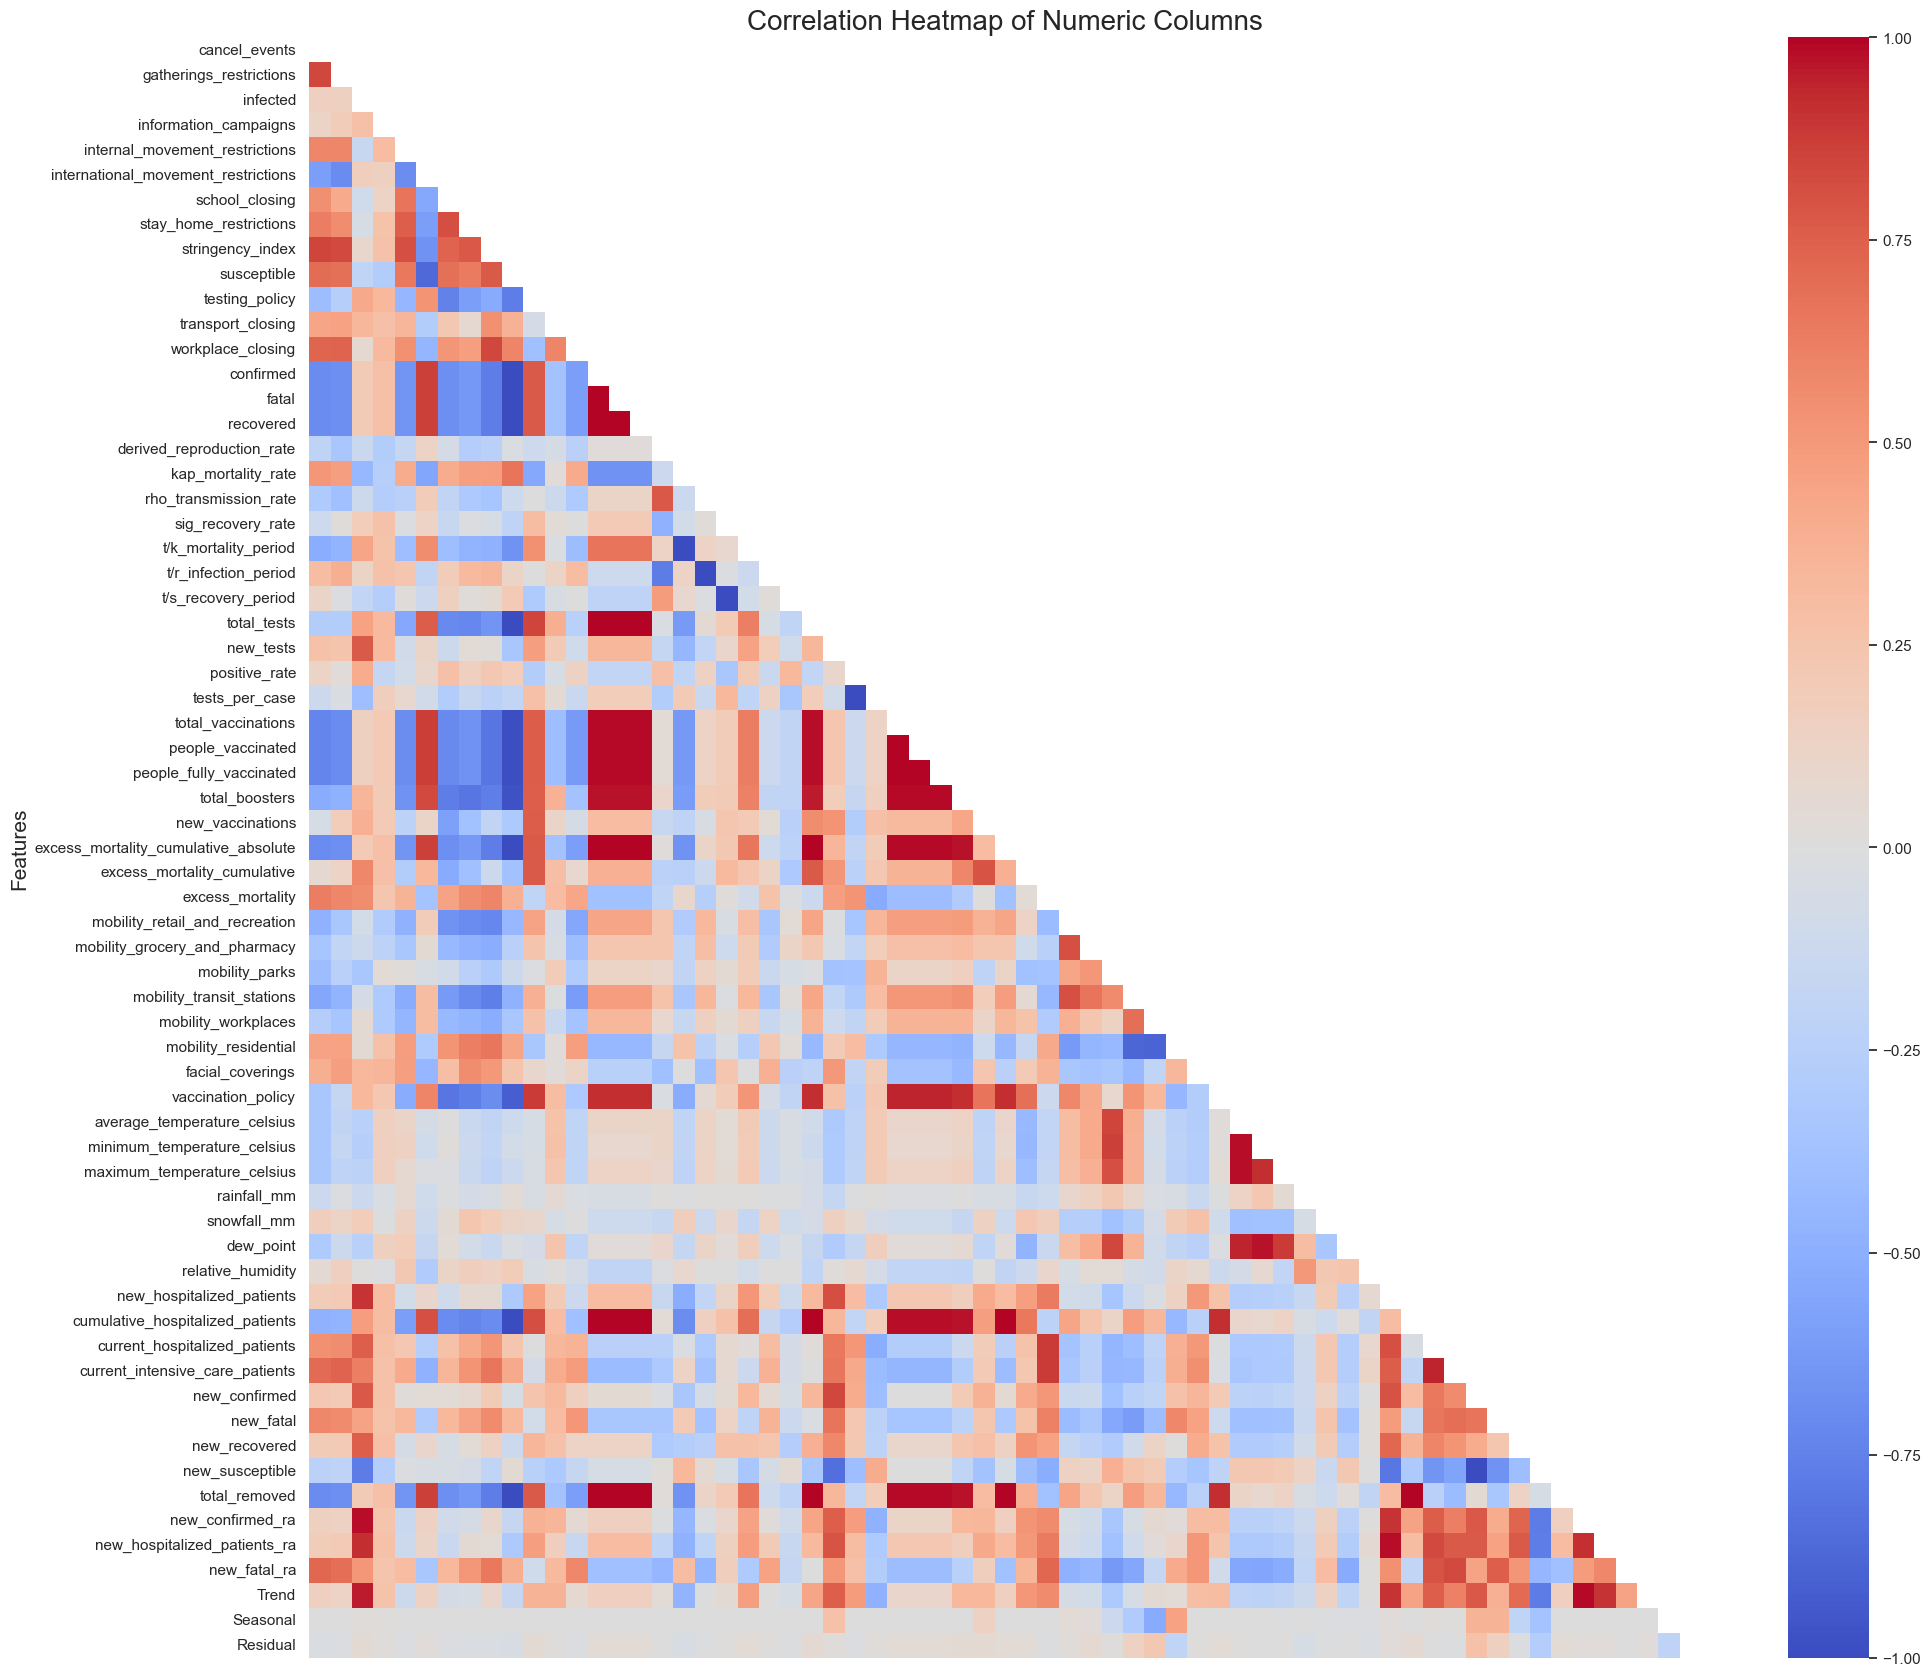

In [ ]:
# Compute the correlation matrix for the Iris DataFrame. This will give us the correlation coefficient between every pair of features (including the target).
# Calculate all the correlations between each independent variables
corr_df = master_df.corr('spearman')

# Mask for upper-triangular
mask = np.triu(corr_df)
plt.figure(figsize=(20,20))
sns.heatmap(corr_df.round(2), vmax=1, vmin=-1, cmap='coolwarm', mask=mask, center=0)
plt.title('Correlation Heatmap of Numeric Columns', fontsize=20)
plt.ylabel('Features', fontsize=15)
plt.xticks([])
plt.show()

# Display the correlation matrix, transposed for readability and sorted by the 'target' column. This gives us an idea of which features are most strongly correlated with the target.
# The 'style.background_gradient' method is used to apply a color gradient to the 'target' column, making it easier to visually identify high and low correlation values.
# display(correlation.T.sort_values('target').style.background_gradient(subset='target', cmap='coolwarm'))


$$R_0 = \frac{\text{transmission rate}}{\text{recovery rate} + \text{mortality rate}}$$

In [ ]:
# Create pairplot of the Iris DataFrame, colored by the 'target' column. This helps visualize the distribution and relationship of each pair of features.
sns.pairplot(df, hue='target')
plt.show()


### <a id='toc1_2_3_'></a>[Advanced EDA: Clustering](#toc0_)

In [ ]:
# Prepare the feature matrix by dropping the 'target' column from the original DataFrame.
X = df.drop('target', axis=1)

# Standardize the features to have a mean of 0 and standard deviation of 1. This is necessary for many machine learning algorithms.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform K-Means clustering on the standardized features, specifying 3 clusters (to match the number of Iris species).
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(X_scaled)

# Add the cluster labels generated by K-Means to the original DataFrame.
df['cluster'] = kmeans.labels_

# Create pairplot of the Iris DataFrame, this time colored by the 'cluster' column. This helps visualize how well K-Means was able to separate the different Iris species.
sns.pairplot(df, hue='cluster')
plt.show()


## <a id='toc1_3_'></a>[Insights and Conclusions](#toc0_)

Based on the univariate and bivariate analysis we performed on the Iris dataset, we can make the following observations:

1. **Univariate Analysis**: The variables 'sepal_width', 'sepal_length', 'petal_width', and 'petal_length' all follow a somewhat normal distribution, with some having a slightly skewed distribution. The 'species' variable, which is categorical, has an equal distribution of classes, meaning we have a balanced dataset.

2. **Bivariate Analysis**: The correlation matrix and pairplot give us an idea of the relationship between variables. 'Petal_length' and 'petal_width' show a strong positive correlation, meaning they increase together. Similarly, 'sepal_length' and 'petal_length' as well as 'sepal_length' and 'petal_width' show a strong positive correlation. 'Sepal_length' and 'sepal_width' show a negative correlation, meaning as one increases, the other decreases. These correlations indicate that petal measurements may be a good predictor of species type.

3. **Clustering Analysis**: KMeans clustering was performed on the data and it grouped the data into three clusters. When we compare these clusters with the original 'species' labels, we can see a good overlap, which indicates that the clusters formed are meaningful and reflect the natural groupings in the data. However, there are some misclassifications, particularly between the Versicolor and Virginica species. This could be due to the fact that these two species are more similar to each other in terms of sepal and petal measurements compared to the Setosa species, which is more distinct.

In conclusion, this analysis shows that the Iris dataset has meaningful and significant patterns that can be captured using statistical analysis and machine learning techniques. These patterns are reflective of the underlying biological differences between different species of Iris flowers.